# Dog Breed Classification

## Introduction

[ImageNet](https://www.image-net.org/) is one of the most popular datasets in computer vision, used mainly for image classification and localisation. Due to its vast size, subsets of this dataset can also be constructed to focus on specific problems. One such dataset is the [Stanford Dogs Dataset](https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset/data), containing images of several breeds of dogs, designed for fine-grained image categorisation.

In this assignment, you will be constructing and training neural network-based models to identify the breed of the dog shown in an image. Therefore, the models that will be considered fall under the category of object recognition. Hence, many concepts in related fields (e.g. face recognition) are also applicable here.

**Acknowledgements**

The original data source can be found at http://vision.stanford.edu/aditya86/ImageNetDogs/.

*⚠️ NOTE: The link does not use https to establish a secure connection and thus you may get a security warning if you attempt to access it. Instructions on how to use the dataset will be given below.*

**Reference:**

  Aditya Khosla, Nityananda Jayadevaprakash, Bangpeng Yao and Li Fei-Fei. Novel dataset for Fine-Grained Image Categorization. First Workshop on Fine-Grained Visual Categorization (FGVC), IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2011.

**ImageNet Reference:**

  J. Deng, W. Dong, R. Socher, L.-J. Li, K. Li and L. Fei-Fei, ImageNet: A Large-Scale Hierarchical Image Database. IEEE Computer Vision and Pattern Recognition (CVPR), 2009.

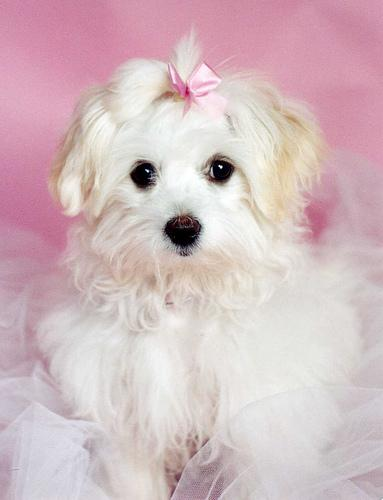

## Instructions
- The dataset is available by accessing the MECC storage (via Networks labs PCs), at `/opt/nfs/shared/images/ImageNetDogs`. The files and folders of interest are as follows:
 - **Images**: Image files
 - **Annotation**: Annotation files, containing metadata such as bounding boxes around the dog in the image
 - **README.txt**: Some information on the dataset

 *⚠️ NOTE: For this assignment, you DO NOT need to use any other files, such as file_list.mat, test_data.mat, etc.*

- This assignment is to be attempted individually.

- All code needs to be developed in Python 3. This Jupyter notebook should be used, and uploaded to the VLE once complete.

- Computers in the Networks lab can be used to train the models required to complete this assignment. It is HIGHLY recommended to use the GPUs.

- Any textual or visual information and equations that might need to be conveyed is expected to be written using the Markdown language.

- The Jupyter notebook to be submitted should be named as follows:

  `name-surname-idnumber.ipynb`

- The list of packages that are allowed for this assignment are as follows: `matplotlib`, `os`, `numpy`, `torch`, `open-cv`, `xml`, `PIL`, `torchvision` and any other packages agreed with the lecturer.

- If you use any information or material from books, papers, websites, etc., please ensure that the appropriate citations are included.

- The deadline for this assignment is **Friday, 17th January 2025 at 15:00**.

## Package Imports

Import all of the packages required in the notebook

In [1]:
# Import os for file operations
import os

# Import numpy for numerical operations
import numpy as np

# Import random for random number generation
import random

# Import PIL and matplotlib for image operations
from PIL import Image
import matplotlib.pyplot as plt

# Import torch for GPU Data processing
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

# Import torchvision for  Data transformation
from torchvision import transforms
import torchvision.models as torchmodels


# Import tqdm for visualizing progress bar
from tqdm.notebook import tqdm

# Import xmltodict for parsing xml files
import xmltodict

## Device Check

In [2]:

# Check and print GPU information if available
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("No GPU available, using CPU")
    device = torch.device("cpu")

print(f"Device set to: {device}")

Using GPU: NVIDIA GeForce RTX 3060
Device set to: cuda


## The Data

### **Q1: Dataset Exploration** ###

Explore the dataset, to determine the characteristics of the data that you're using. Write down any observations.

*ℹ️ NOTE: Feel free to display a few examples, to get an idea of the image characteristics. Observing and understanding the characteristics of a dataset should help you design an effective way to split your data and any precautions or considerations requred when constructing your models (e.g. identifying any issues that may arise, allowing you to take preventative action). Things you could check out include the image quality, resolution, total number of images, number of classes, distribution of the number of images per class, etc.*

**(5 marks)**

Dataset directory structure:
/opt/nfs/shared/images/ImageNetDogs
├── Annotation
├── file_list.mat
├── Images
├── README.txt
├── test_data.mat
├── test_list.mat
├── train_data.mat
└── train_list.mat

2 directories, 6 files

Images folder structure:
/opt/nfs/shared/images/ImageNetDogs/Images/n02085620-Chihuahua:                      directory
/opt/nfs/shared/images/ImageNetDogs/Images/n02085782-Japanese_spaniel:               directory
/opt/nfs/shared/images/ImageNetDogs/Images/n02085936-Maltese_dog:                    directory
/opt/nfs/shared/images/ImageNetDogs/Images/n02086079-Pekinese:                       directory
/opt/nfs/shared/images/ImageNetDogs/Images/n02086240-Shih-Tzu:                       directory

Number of Categories:
120

Total number of images:
20580
4 random images:


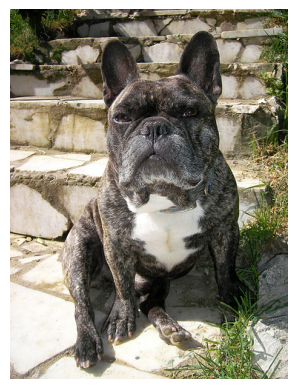


Image 1 resolution:
/opt/nfs/shared/images/ImageNetDogs/Images/n02108915-French_bulldog/n02108915_1188.jpg : (375, 500) pixels


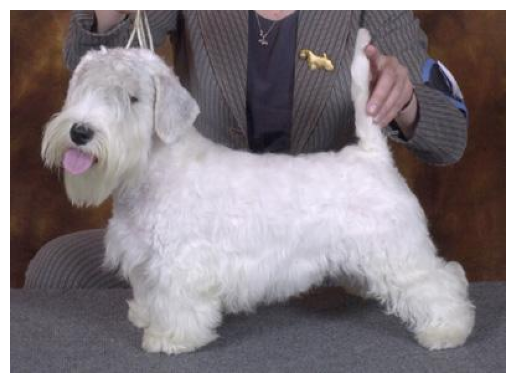


Image 2 resolution:
/opt/nfs/shared/images/ImageNetDogs/Images/n02095889-Sealyham_terrier/n02095889_4432.jpg : (400, 293) pixels


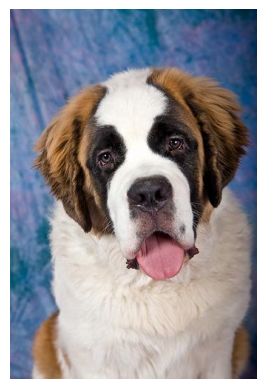


Image 3 resolution:
/opt/nfs/shared/images/ImageNetDogs/Images/n02109525-Saint_Bernard/n02109525_14999.jpg : (334, 500) pixels


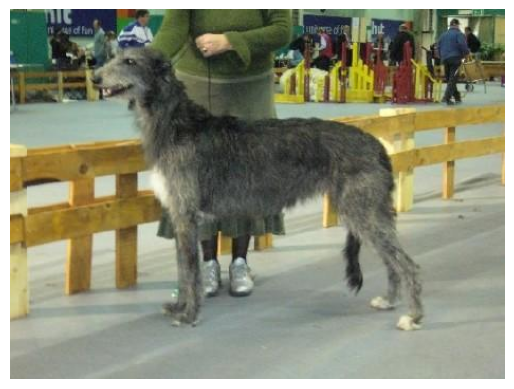


Image 4 resolution:
/opt/nfs/shared/images/ImageNetDogs/Images/n02092002-Scottish_deerhound/n02092002_7667.jpg : (468, 350) pixels


In [3]:
# Define dataset directory
dataset_dir = '/opt/nfs/shared/images/ImageNetDogs'

# List dataset contents
print("Dataset directory structure:")
os.system(f'tree {dataset_dir} -L 1')

# Read the README file
#print("\nREADME file:")
#os.system(f'cat {dataset_dir}/README.txt')

# Check the structure of the Images Folder
print("\nImages folder structure:")
os.system(f'file {dataset_dir}/Images/* | head -n 5')

# Number of Categories
print("\nNumber of Categories:")
os.system(f'ls {dataset_dir}/Images | wc -l')

# Number of total images in Images folder
print("\nTotal number of images:")
os.system(f'find {dataset_dir}/Images -type f | wc -l')

# Declare the number of random images to display
ran_img = 4
# Load, display and analyze 4 random images
print(str(ran_img) + " random images:")
for i in range(ran_img):
    img_path = os.popen(f'find {dataset_dir}/Images -type f | shuf -n 1').read().strip()
    img = Image.open(img_path)
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    
    # Check the image resolution
    print("\nImage " + str(i+1) + " resolution:")
    print(f"{img_path} : {img.size} pixels")

**A1**: Write your answer here.


### **Q2: Splitting the dataset** ###
Implement code to split the dataset in such a way as to enable training and testing of a machine learning model.

**(5 marks)**

In [4]:

def split_dataset(data_dir, train_ratio=0.7, val_ratio=0.15, num_classes=None, seed=None):

    # Set seed for reproducibility if provided
    if seed is not None:
        random.seed(seed)
    # Otherwise, set a random seed
    else:
        random.seed()

    # Get the sorted list of classifications
    classes = sorted(os.listdir(data_dir))

    # Check if a specified number of classes is provided
    if num_classes is not None:
        # Make an upper bound to the number of classes
        classes = classes[:num_classes]

    # Create a dictionary mapping the class breed names to integers
    breed_dict = {breed: i for i, breed in enumerate(classes)}

    # Initialize the 3 splits sets
    train_set = []
    val_set = []
    test_set = []

    # Iterate over the classes
    for breed in classes:
        # Get the list of images for the current class
        img_list = os.listdir(os.path.join(data_dir, breed))
        # Make sure only images are captured
        img_list = [img for img in img_list if img.endswith('.jpg')]
        
        # Shuffle the list of images
        random.shuffle(img_list)

        # Calculate the split indexes
        num_train = int(len(img_list) * train_ratio)
        num_val = int(len(img_list) * val_ratio)
        num_test = len(img_list) - num_train - num_val
        
        # Split the images into the 3 sets
        train_set += [(os.path.join(data_dir, breed, img), breed_dict[breed]) for img in img_list[:num_train]]
        val_set += [(os.path.join(data_dir, breed, img), breed_dict[breed]) for img in img_list[num_train:num_train + num_val]]
        test_set += [(os.path.join(data_dir, breed, img), breed_dict[breed]) for img in img_list[num_train + num_val:]]

    return train_set, val_set, test_set, breed_dict

### **Q3: Custom dataset in PyTorch** ###

A lot of effort in solving any machine learning and computer vision problem goes into preparing the data. PyTorch provides a simple mechanism to define a custom dataset using `torch.utils.data.Dataset`, which is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:

- `__init__` so that it initialises the dataset
- `__len__` so that len(dataset) returns the size of the dataset.
- `__getitem__` to support the indexing such that `dataset[i]` can be used to get $i$-th sample.


Write a class `DataLoaderClassification` that can be used to
- Load the list of image filenames and the corresponding lables in two lists in `__init__`
- Load a batch of images and corresponding lables when one calls `__getitem__`
- Returns the length of the dataset using `__len__`

*ℹ️ NOTE: It is recommended to make use of the bounding boxes...*

**(5 marks)**

In [5]:
class DataLoaderClassification(Dataset):
    def __init__(self, image_set, breed_dict, transform=None):
        
        self.image_set = image_set
        self.transform = transform
        self.breed_dict = breed_dict

    def __len__(self):
        return len(self.image_set)

    
    def __getitem__(self, idx):
        img_path = self.image_set[idx][0]
        
        # Make sure the image file exists
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file not found: {img_path}")
    
        # Open the image
        img = Image.open(img_path)
        
        # Get the respective bounding box file path
        bbox_path = img_path.replace('Images', 'Annotation').removesuffix('.jpg') 
        
        # Check if the bounding box file exists
        if not os.path.exists(bbox_path):
            raise FileNotFoundError(f"Bounding box file not found: {bbox_path}")
        
        # Parse the bounding box XML file
        with open(bbox_path) as fd:
            doc = xmltodict.parse(fd.read())
        
        # Handle multiple objects in the annotation
        objects = doc['annotation']['object']
        if isinstance(objects, list):
            bndbox = objects[0]['bndbox']  # Use the first object's bounding box
        else:
            bndbox = objects['bndbox']
        
        xmin = int(bndbox['xmin'])
        ymin = int(bndbox['ymin'])
        xmax = int(bndbox['xmax'])
        ymax = int(bndbox['ymax'])
            
        # Crop the image using the bounding box coordinates
        img = img.crop((xmin, ymin, xmax, ymax))
        
        # Apply transformation if any
        if self.transform:
            img = self.transform(img)
        
        # Get the label from the image path using the breed_to_label dictionary
        label = self.breed_dict[img_path.split('/')[-2]]
        
        return img, label

### **Q4: PyTorch dataloaders** ###

Write code that creates the PyTorch dataloaders to train and test the model.

**(5 marks)**

In [6]:
# Define the mean and std standards to be used consistently 
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define the transformation to be applied on the training set
train_transform = transforms.Compose([
    # We perform data augmentation in the training set to reduce overfitting
    #transforms.RandomResizedCrop(128),
    #transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Resize((128, 128)),
    transforms.Lambda(lambda img: img.convert('RGB')),  
    transforms.ToTensor(),
    # Normalize the image to the defined mean and std
    #transforms.Normalize(mean, std)
])
# Note we resize before converting to tensor, since in PIL format it is easier to resize and less computationally expensive


# Define the transformation to be applied on the validation set
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Lambda(lambda img: img.convert('RGB')), 
    transforms.ToTensor(),
    #transforms.Normalize(mean, std)
])


# Define the dataset image directory
directory = '/opt/nfs/shared/images/ImageNetDogs/Images'

# Split the dataset using the split_dataset function
train_set, val_set, test_set, breed_dict = split_dataset(directory, train_ratio=0.7, val_ratio=0.15)

# Set the number of classes
num_classes = len(breed_dict)

# Reverse dictionary to map labels to breed names
label_dict = {label: breed for breed, label in breed_dict.items()}

# Initialize the DataLoader class instances for the train, val and test sets
train_loader = DataLoaderClassification(train_set, breed_dict, transform=train_transform)
val_loader = DataLoaderClassification(val_set, breed_dict, transform=val_transform)
test_loader = DataLoaderClassification(test_set, breed_dict, transform=val_transform)

# Define the batch size
batch_size = 64

# Create the DataLoader objects for the train, val and test sets
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_loader, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_loader, batch_size=batch_size, shuffle=False)


# Verify the data loaders
total_samples = int(os.popen(f'find {directory} -type f | wc -l').read().strip())
train_samples = len(train_loader.dataset)
val_samples = len(val_loader.dataset)
test_samples = len(test_loader.dataset)
print(f"Total samples in the dataset: {total_samples}")
print(f"Samples in the training set: {train_samples}")
print(f"Samples in the validation set: {val_samples}")
print(f"Samples in the test set: {test_samples}")

if total_samples == (train_samples + val_samples + test_samples):
    print("Data split successful")
else:
    print("Data split unsuccessful")
    print(f"Total samples is meant to be {total_samples} but got {train_samples + val_samples + test_samples}")

Total samples in the dataset: 20580
Samples in the training set: 14355
Samples in the validation set: 3025
Samples in the test set: 3200
Data split successful


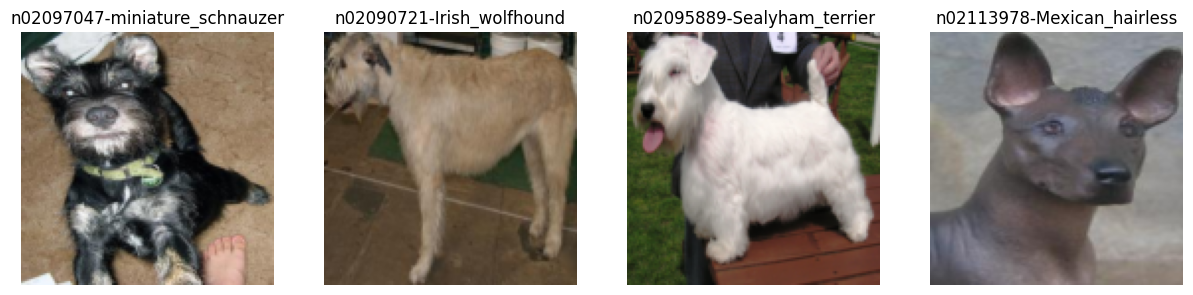

In [7]:
def visualize_batch(loader, label_dict, num_samples=4):
    # Get random samples from the data loader
    random.seed()
    indices = random.sample(range(len(loader.dataset)), num_samples)
    images, labels = zip(*[loader.dataset[i] for i in indices])
    
    # Plot the images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.permute(1, 2, 0))  # Convert from Tensor image format to numpy image format
        ax.set_title(label_dict[label])
        ax.axis('off')
    plt.show()

# Visualize the training set
visualize_batch(train_loader, label_dict)

## Simple CNN

### **Q5: Define a simple CNN** ###

PyTorch provides the elegantly designed modules and classes, including `torch.nn`, to help you create and train neural networks. An `nn.Module` contains layers, and a method `forward(input)` that returns the output.

Write the `CNN` class to define a Convolutional Neural Network (CNN) where:
- The first convolutional layer (`conv1`) takes 3 input channels, outputs 16 output channels and has a kernel size of 5, a stride of 1, and padding of 2 pixels. The output of `conv1` is fed into a ReLU activation followed by a Max-pooling operator with a kernel size of 2.
- The second convolutional layer in this network (`conv2`) should have 32 filters with a kernel size of 5, a stride of 1, and padding of 2 pixels. This should be followed by a ReLU activation and a max-pooling operator with a kernel size of 2.
- The last layer is a fully-connected layer (`fc1`), which will finally output the dog breed that needs to be predicted.

In this code you should define the `__init__` and `forward` member functions.

Lastly, print the number of parameters in the model (using `torchsummary.summary`)

More information about `torch.nn` can be found [here](https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html).

**(10 marks)**

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Activation function
        self.relu = nn.ReLU()
        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2)
        # The GAP layer got rid of my overfitting problem
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Global average pooling layer

        # Fully connected layer
        self.fc1 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.global_avg_pool(x)  # Apply global average pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)  # Fully connected layer
        return x

# Initialize the CNN
model = CNN()

# Move the model to the device
model = model.to(device)

# Set the model path
model_path = './Model/Simple-CNN/simple-model.pth'

# Print the number of parameters in the model
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
         MaxPool2d-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
              ReLU-5           [-1, 32, 64, 64]               0
         MaxPool2d-6           [-1, 32, 32, 32]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Linear-8                  [-1, 120]           3,960
Total params: 9,048
Trainable params: 9,048
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 6.75
Params size (MB): 0.03
Estimated Total Size (MB): 6.97
----------------------------------------------------------------


### **Q6: Train and evaluate the simple CNN** ###

1.   Write the code to train and evaluate the CNN specified in **Q5**. Use an Adam optimizer with the learning rate set to 0.001.
2.   Plot the accuracy against the number of epochs and write the highest accuracy achieved after 25 epochs.
3.   Save the best performing model in the folder `./Model/Simple-CNN/model.pth`.
4.   Write a function that takes as input (1) a model and (2) an image of a dog, and which outputs the dog's breed using the model.

*ℹ️ NOTE: Apart from the accuracy, feel free to check out any other metrics that may be of relevance. Apart from the overall performance, consider also checking out the performance across classes.*

*ℹ️ NOTE: The model should take less than 1 hour to train.*

**(15 marks)**

In [9]:
def indv_epoch_train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    return epoch_loss, train_accuracy 

In [10]:
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    return val_loss, val_accuracy

In [11]:

def metric_plot(train_accuracies, val_accuracies, train_losses, val_losses, num_epochs):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Epochs')
    plt.grid(True)
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Number of Epochs')
    plt.grid(True)
    plt.legend()

    plt.show()

In [12]:
def save_model(model, model_path, val_acc, best_acc, epoch, optimizer=None, save_condition=None):
   
    save_condition = save_condition or (val_acc > best_acc) or (epoch % 10 == 0)

    if save_condition:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict() if optimizer else None,
            'val_acc': val_acc,
            'best_acc': best_acc,
        }

        # Ensure the directory exists before saving
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        
        torch.save(checkpoint, model_path)
        print(f"Model saved at {model_path}")

        # Update the best accuracy if the current validation accuracy is better
        best_acc = max(val_acc, best_acc)

    return best_acc


Training Progress:   0%|          | 0/25 [00:00<?, ?it/s]

Model saved at ./Model/Simple-CNN/simple-model.pth
Model saved at ./Model/Simple-CNN/simple-model.pth
Model saved at ./Model/Simple-CNN/simple-model.pth
Model saved at ./Model/Simple-CNN/simple-model.pth
Model saved at ./Model/Simple-CNN/simple-model.pth
Model saved at ./Model/Simple-CNN/simple-model.pth
Model saved at ./Model/Simple-CNN/simple-model.pth
Model saved at ./Model/Simple-CNN/simple-model.pth
Model saved at ./Model/Simple-CNN/simple-model.pth
Model saved at ./Model/Simple-CNN/simple-model.pth
Model saved at ./Model/Simple-CNN/simple-model.pth
Model saved at ./Model/Simple-CNN/simple-model.pth
Model saved at ./Model/Simple-CNN/simple-model.pth
Model saved at ./Model/Simple-CNN/simple-model.pth
Model saved at ./Model/Simple-CNN/simple-model.pth
Model saved at ./Model/Simple-CNN/simple-model.pth
Model saved at ./Model/Simple-CNN/simple-model.pth
Model saved at ./Model/Simple-CNN/simple-model.pth
Model saved at ./Model/Simple-CNN/simple-model.pth


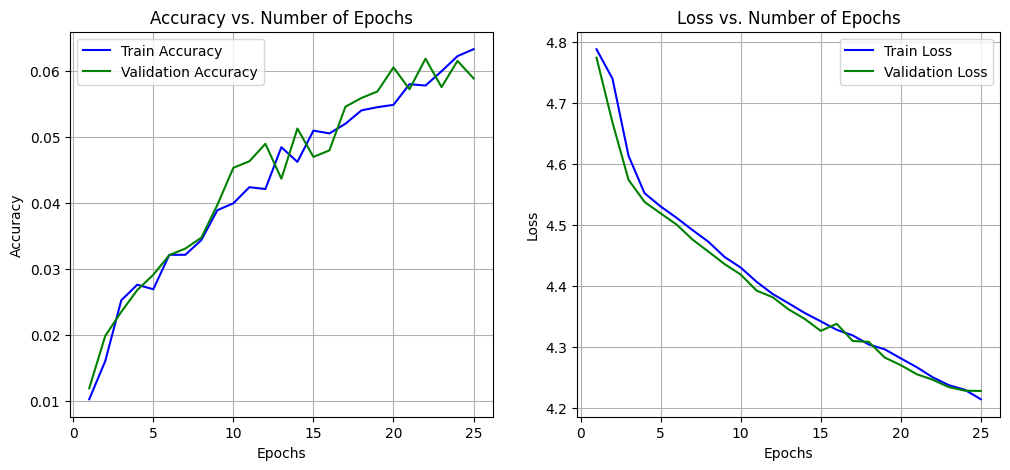

Highest Validation Accuracy: 6.18%


In [13]:

# Define the loss function (Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam, learning rate 0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the number of epochs
num_epochs = 25

# Initialize lists to store the accuracies and losses at each epoch
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []
# Initialize the best accuracy
best_accuracy = 0.0

# Initialize the progress bar for better visualization of the training progress
progress_bar = tqdm(range(num_epochs), desc="Training Progress", dynamic_ncols=True)

# Training loop with progress bar
for epoch in progress_bar:
    ## Training ##
    train_loss, train_accuracy = indv_epoch_train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    ## Evaluation ##
    val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Save the best model as a checkpoint 
    best_accuracy = save_model(model, model_path, val_accuracy, best_accuracy, epoch, optimizer)

    # Update the progress bar with metrics
    progress_bar.set_postfix_str(
        f"Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%"
    )

# Plot the accuracy against the number of epochs
metric_plot(train_accuracies, val_accuracies, train_losses, val_losses, num_epochs)

best_acc_percent = 100 * best_accuracy
# Print the highest accuracy achieved
print(f"Highest Validation Accuracy: {best_acc_percent:.2f}%")


The best accuracy of the proposed network after 25 epochs is **?%**



Write a function that takes as input (1) a model and (2) an image of a dog, and which outputs the dog's breed using the model.

Try it out using an image in your testing set.

In [14]:
def predict(model, model_path, img_path, label_dict, device='cuda' if torch.cuda.is_available() else 'cpu'):
    # Load the model
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Load and preprocess the image
    image = Image.open(img_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize to match model input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Replace with your dataset's mean/std
    ])
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    # Perform the prediction
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        confidence = torch.nn.functional.softmax(outputs, dim=1)[0] * 100

    # Get the predicted breed
    predicted_breed = label_dict.get(predicted.item(), "Unknown Breed")
    confidence = confidence[predicted.item()].item()

    return predicted_breed, confidence

In [15]:
# Set the model path
model_path = './Model/Simple-CNN/model.pth'

# Get a random image path
img_path = random.choice(test_set)[0]
# The [0] is to get the image path from the tuple because before i was returning a tuple of image path and label and getting matching type errors

# Print the image path
print(f"Image Path: {img_path}")

# Predict the breed
breed, confidence = predict(model, model_path, img_path, label_dict)

print(f"Predicted Breed: {breed}")
print(f"Confidence: {confidence:.2f}%")


Image Path: /opt/nfs/shared/images/ImageNetDogs/Images/n02099849-Chesapeake_Bay_retriever/n02099849_4519.jpg
Predicted Breed: n02096585-Boston_bull
Confidence: 9.92%


### **Q7: Improve the simple CNN's performance** ###

Provide an overview of the model's characteristics (e.g. hyperparameters) that can be modified to try and improve performance. Then, try to improve the performance, by varying some characteristics, and train *at least* 1 additional model.

Explain the reasoning behind the hyperparameters chosen for modification, and the reasoning behind the values that are set (e.g. if you reduce the learning rate, explain why you have done this).

Plot the accuracy against the number of epochs and write the highest accuracy achieved after 25 epochs. Show the results of any other metrics that are deemed relevant.

ℹ️ *NOTE: While it is not strictly necessary to improve performance (although desirable), it is important to discuss any increase or decrease in performance, across all evaluation metrics considered (i.e. discuss why did performance increase/decrease?)*

ℹ️ *NOTE: Do NOT change the number of epochs. Similar to the model in Q6, the models should take less than 1 hour each to train.**

**(10 marks)**

In [16]:
import torch.nn as nn
import torch

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes, init=32, dropout=0.5): 
        super(ImprovedCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=init, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=init, out_channels=init*2, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=init*2, out_channels=init*4, kernel_size=5, stride=1, padding=2)

        # Batch Normalization layers
        self.bn1 = nn.BatchNorm2d(init)
        self.bn2 = nn.BatchNorm2d(init*2)
        self.bn3 = nn.BatchNorm2d(init*4)

        # Activation function
        self.relu = nn.ReLU()

        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layers
        self.fc1 = nn.Linear(init * 4, 64)  # Bottleneck to 64
        self.fc2 = nn.Linear(64, num_classes)  # Final layer matching num_classes

    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Second convolutional block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)

        # Third convolutional block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)

        # Flatten the output to spatial dimension of 1
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)  # Bottleneck layer
        x = self.relu(x)  # Apply activation
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)  # Final layer with class scores

        # Note the bottle neck approach may seem 
        return x

# Initialize the Improved CNN
improved_model = ImprovedCNN(num_classes)

# Move the model to the device
improved_model = improved_model.to(device)

# Set the model path
improved_model_path = './Model/Improved-CNN/improved_model.pth'

# Print the model summary 
summary(improved_model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]           2,432
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          51,264
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]         204,928
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
AdaptiveAvgPool2d-13            [-1, 128, 1, 1]               0
           Linear-14                   

Training Progress:   0%|          | 0/25 [00:00<?, ?it/s]

Model saved at ./Model/Improved-CNN/improved_model.pth
Model saved at ./Model/Improved-CNN/improved_model.pth
Model saved at ./Model/Improved-CNN/improved_model.pth
Model saved at ./Model/Improved-CNN/improved_model.pth
Model saved at ./Model/Improved-CNN/improved_model.pth
Model saved at ./Model/Improved-CNN/improved_model.pth
Model saved at ./Model/Improved-CNN/improved_model.pth
Model saved at ./Model/Improved-CNN/improved_model.pth
Model saved at ./Model/Improved-CNN/improved_model.pth
Model saved at ./Model/Improved-CNN/improved_model.pth
Model saved at ./Model/Improved-CNN/improved_model.pth
Model saved at ./Model/Improved-CNN/improved_model.pth
Model saved at ./Model/Improved-CNN/improved_model.pth
Model saved at ./Model/Improved-CNN/improved_model.pth


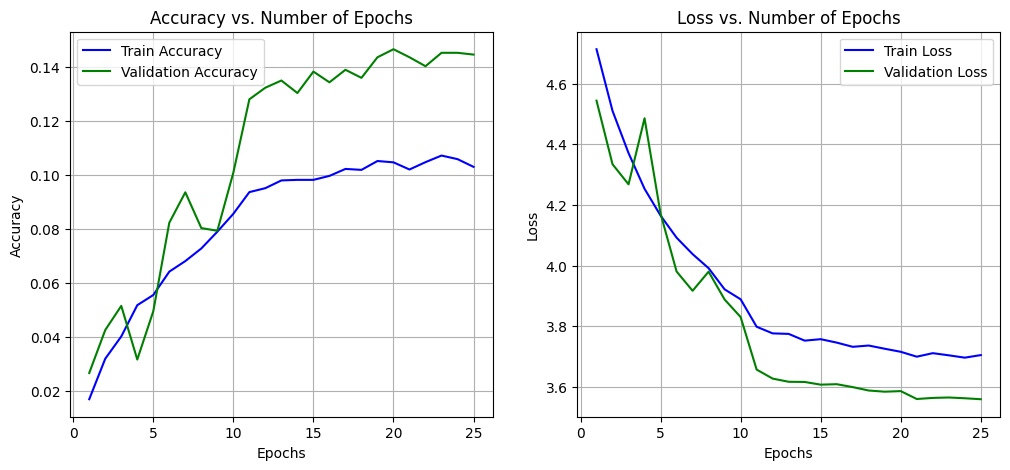

Highest Validation Accuracy: 14.64%


In [17]:

# Define the loss function (Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam, learning rate 0.0005)
optimizer = optim.Adam(improved_model.parameters(), lr=0.0005)

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce LR by factor of 0.1 every 10 epochs

# Define the number of epochs
num_epochs = 25

# Initialize lists to store the accuracies and losses at each epoch
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

# Initialize the best accuracy
best_accuracy = 0.0

# Initialize the progress bar for better visualization of the training progress
progress_bar = tqdm(range(num_epochs), desc="Training Progress", dynamic_ncols=True)

# Training loop with progress bar
for epoch in progress_bar:
    ## Training ##
    train_loss, train_accuracy = indv_epoch_train(improved_model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    ## Evaluation ##
    val_loss, val_accuracy = evaluate_model(improved_model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Step the scheduler
    scheduler.step()

    # Save the best model as a checkpoint 
    best_accuracy = save_model(improved_model, improved_model_path, val_accuracy, best_accuracy, epoch, optimizer)

    # Update the progress bar with metrics
    progress_bar.set_postfix_str(
        f"Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}"
    )

# Plot the accuracy against the number of epochs
metric_plot(train_accuracies, val_accuracies, train_losses, val_losses, num_epochs)

best_acc_percent = 100 * best_accuracy
# Print the highest accuracy achieved
print(f"Highest Validation Accuracy: {best_acc_percent:.2f}%")


In [18]:
# Set the model path
improved_model_path = './Model/Improved-CNN/model.pth'

# Get a random image path
img_path = random.choice(test_set)[0]

# Print the image path
print(f"Image Path: {img_path}")

# Predict the breed
breed, confidence = predict(improved_model, improved_model_path, img_path, label_dict)

print(f"Predicted Breed: {breed}")
print(f"Confidence: {confidence:.2f}%") 

Image Path: /opt/nfs/shared/images/ImageNetDogs/Images/n02106030-collie/n02106030_17586.jpg
Predicted Breed: n02085782-Japanese_spaniel
Confidence: 17.02%


## Deep CNNs

### **Q8: Understanding deep CNN architectures proposed in literature** ###

There are several deep CNN methods that achieve very high classification rates. The following is a list of papers that you should check out:

1. Alexnet  [[1]](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
2. VGG model [[2]](https://www.robots.ox.ac.uk/~vgg/publications/2015/Simonyan15/simonyan15.pdf)
3. ResNet [[3]](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)

Discuss what innovations each network introduced, and what contributed to increased performance.

**(10 marks)**

**A8**: Write your answer here.


### **Q9: Define, train, and evaluate a deep CNN** ###

Based on your observations in **Q8**, write the class for a deep CNN model that aims to achieve a better performance than the simple CNN model above, explaining the reasoning behind the design of your model. The number of model parameters should be less than 75M.

Train the model, and plot the accuracy against the number of epochs and write the highest accuracy achieved after 50 epochs. Show the results of any other metrics that are deemed relevant, and discuss your observations.

*ℹ️ NOTE: The model should take less than 3 hours to train.*

**(10 marks)**

In [19]:
class DeepCNN(nn.Module):
    def __init__(self, num_classes, init_channels=32, depth=5):
        super(DeepCNN, self).__init__()

        # Cap initial channels for regularization
        init_channels = min(init_channels, 64)  
        self.features = self.build_features(init_channels, depth)

        # Global average pooling and classifier
        final_channels = min(init_channels * (2 ** (depth - 1)), 2048)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(final_channels, num_classes)

    def build_features(self, init_channels, depth):
        """Builds the convolutional and pooling layers dynamically."""
        layers = nn.Sequential()
        in_channels = 3  # Input is RGB images
        
        for i in range(depth):
            # Set the number of output channels for this layer
            out_channels = min(init_channels * (2 ** i), 2048)

            # Add the convolutional block
            layers.add_module(f'conv{i+1}', self.conv_block(in_channels, out_channels))
            
            # Add pooling after every two convolutional layers except the last
            if (i % 2 == 1) and (i != depth - 1):
                layers.add_module(f'pool{i+1}', nn.MaxPool2d(2, 2))

            # Update input channels for the next layer
            in_channels = out_channels
        
        return layers

    def conv_block(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        """Creates a single convolutional block with BatchNorm and ReLU."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Feature extraction
        x = self.features(x)
        
        # Global average pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        # Classification
        x = self.classifier(x)
        return x
"""
# These are all the convolutional layers grouped together in a sequential block making it easier to manage the depth and choosing the number of layers
 # Our in will always be 3 since we are working with RGB images

# Create the respective out channels for iteration of layer depth but we limit it to 2048 channels for regularization

# To reduce the spatial dimensions of the feature maps more gradually we add pooling layers to every pair of convolutional layers
# Add pooling after every pair of convolutional layers and exclude the last pair

# For the last layer we add residual connections to the output of the last pooling layer and a global average pooling 
"""

# Initialize the Deep CNN
deep_model = DeepCNN(num_classes)

# Move the model to the device
deep_model = deep_model.to(device)

# Set the model path
deep_model_path = './Model/Deep-CNN/deep-model.pth'

# Print the model summary to check parameters
summary(deep_model, (3, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,432
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]          73,728
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         294,912
      BatchNorm2d-12          [-1, 256, 64, 64]             512
             ReLU-13          [-1, 256, 64, 64]               0
        MaxPool2d-14          [-1, 256,

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Model saved at ./Model/Deep-CNN/deep-model.pth
Model saved at ./Model/Deep-CNN/deep-model.pth
Model saved at ./Model/Deep-CNN/deep-model.pth
Model saved at ./Model/Deep-CNN/deep-model.pth
Model saved at ./Model/Deep-CNN/deep-model.pth
Model saved at ./Model/Deep-CNN/deep-model.pth
Model saved at ./Model/Deep-CNN/deep-model.pth
Model saved at ./Model/Deep-CNN/deep-model.pth
Model saved at ./Model/Deep-CNN/deep-model.pth
Model saved at ./Model/Deep-CNN/deep-model.pth
Model saved at ./Model/Deep-CNN/deep-model.pth
Model saved at ./Model/Deep-CNN/deep-model.pth
Model saved at ./Model/Deep-CNN/deep-model.pth
Model saved at ./Model/Deep-CNN/deep-model.pth
Model saved at ./Model/Deep-CNN/deep-model.pth
Model saved at ./Model/Deep-CNN/deep-model.pth
Model saved at ./Model/Deep-CNN/deep-model.pth
Model saved at ./Model/Deep-CNN/deep-model.pth
Model saved at ./Model/Deep-CNN/deep-model.pth
Model saved at ./Model/Deep-CNN/deep-model.pth
Model saved at ./Model/Deep-CNN/deep-model.pth
Model saved a

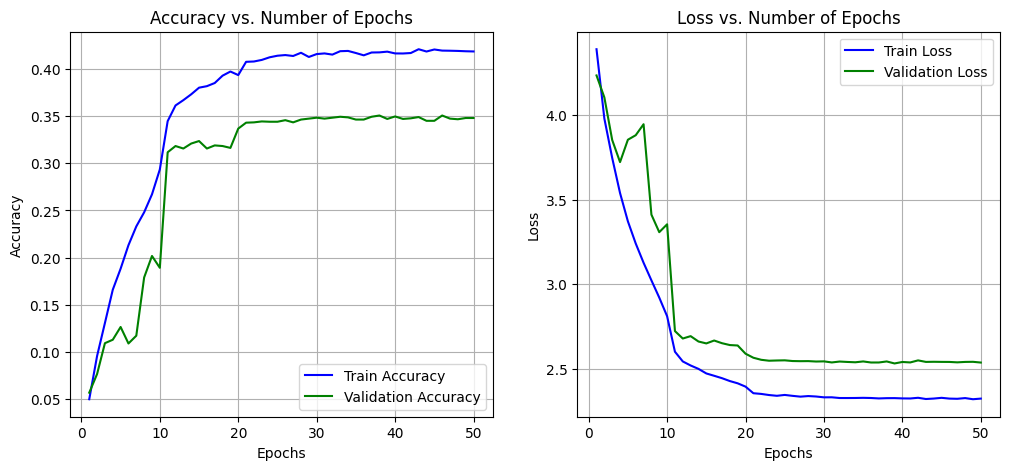

Highest Validation Accuracy: 35.07%


In [20]:

# Define the loss function (Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam, learning rate 0.0005)
optimizer = optim.Adam(deep_model.parameters(), lr=0.0005)

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce LR by factor of 0.1 every 10 epochs

# Define the number of epochs
num_epochs = 50

# Initialize lists to store the accuracies and losses at each epoch
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

# Initialize the best accuracy
best_accuracy = 0.0

# Initialize the progress bar for better visualization of the training progress
progress_bar = tqdm(range(num_epochs), desc="Training Progress", dynamic_ncols=True)

# Training loop with progress bar
for epoch in progress_bar:
    ## Training ##
    train_loss, train_accuracy = indv_epoch_train(deep_model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    ## Evaluation ##
    val_loss, val_accuracy = evaluate_model(deep_model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Step the scheduler
    scheduler.step()

    # Save the best model as a checkpoint 
    best_accuracy = save_model(deep_model, deep_model_path, val_accuracy, best_accuracy, epoch, optimizer)

    # Update the progress bar with metrics
    progress_bar.set_postfix_str(
        f"Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}"
    )

# Plot the accuracy against the number of epochs
metric_plot(train_accuracies, val_accuracies, train_losses, val_losses, num_epochs)

best_acc_percent = 100 * best_accuracy
# Print the highest accuracy achieved
print(f"Highest Validation Accuracy: {best_acc_percent:.2f}%")


In [21]:
# Set the model path
deep_model_path = './Model/Deep-CNN/model.pth'

# Get a random image path
img_path = random.choice(test_set)[0]

# Print the image path
print(f"Image Path: {img_path}")

# Predict the breed
breed, confidence = predict(deep_model, deep_model_path, img_path, label_dict)

print(f"Predicted Breed: {breed}")
print(f"Confidence: {confidence:.2f}%")

Image Path: /opt/nfs/shared/images/ImageNetDogs/Images/n02111277-Newfoundland/n02111277_3297.jpg
Predicted Breed: n02099429-curly-coated_retriever
Confidence: 11.89%


### **Q10: Perform Transfer Learning** ###

Use the [`vgg16_bn` *pre-trained* model](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16_bn.html#torchvision.models.vgg16_bn), using `weights='IMAGENET1K_V1'`, to perform transfer learning using the Stanford Dogs dataset.

Explain the modifications and implementations done to perform transfer learning, in the Markdown text cell below.

Based on your observations of the trained model's performance, try to improve the performance by training additional models (see the cell below for more details).

For each case:

* Plot the accuracy against the number of epochs and write the highest accuracy achieved after 50 epochs. Similar to previous questions, show the results of any other metrics that are deemed relevant.

* Discuss how you are performing the fine-tuning

* Discuss observations from model training and evaluation

*ℹ️ *NOTE: Feel free to use the function you created in Q6 to input an image and a model and output the breed of the dog depicted in the image as determined by the model.*

*ℹ️ NOTE: The model should take less than 2.5 hours to train.*

**(15 marks)**

**A10**: Write your answer here.

In [22]:
# Initialize the VGG16_bn model
vgg16_bn_model = torchmodels.vgg16_bn(weights='IMAGENET1K_V1')

# Change the last layer output to match the number of classes
vgg16_bn_model.classifier[6] = nn.Linear(4096, num_classes)

# Move the model to the device
vgg16_bn_model = vgg16_bn_model.to(device)

# Set the model path
vgg16_bn_model_path = './Model/VGG16/vgg16_bn_model.pth'

# Print the model summary to check parameters
summary(vgg16_bn_model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]          73,856
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
        MaxPool2d-14          [-1, 128,

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Model saved at ./Model/VGG16/vgg16_bn_model.pth
Model saved at ./Model/VGG16/vgg16_bn_model.pth
Model saved at ./Model/VGG16/vgg16_bn_model.pth
Model saved at ./Model/VGG16/vgg16_bn_model.pth
Model saved at ./Model/VGG16/vgg16_bn_model.pth
Model saved at ./Model/VGG16/vgg16_bn_model.pth
Model saved at ./Model/VGG16/vgg16_bn_model.pth
Model saved at ./Model/VGG16/vgg16_bn_model.pth
Model saved at ./Model/VGG16/vgg16_bn_model.pth
Model saved at ./Model/VGG16/vgg16_bn_model.pth
Model saved at ./Model/VGG16/vgg16_bn_model.pth
Model saved at ./Model/VGG16/vgg16_bn_model.pth
Model saved at ./Model/VGG16/vgg16_bn_model.pth
Model saved at ./Model/VGG16/vgg16_bn_model.pth
Model saved at ./Model/VGG16/vgg16_bn_model.pth
Model saved at ./Model/VGG16/vgg16_bn_model.pth
Model saved at ./Model/VGG16/vgg16_bn_model.pth
Model saved at ./Model/VGG16/vgg16_bn_model.pth
Model saved at ./Model/VGG16/vgg16_bn_model.pth
Model saved at ./Model/VGG16/vgg16_bn_model.pth
Model saved at ./Model/VGG16/vgg16_bn_mo

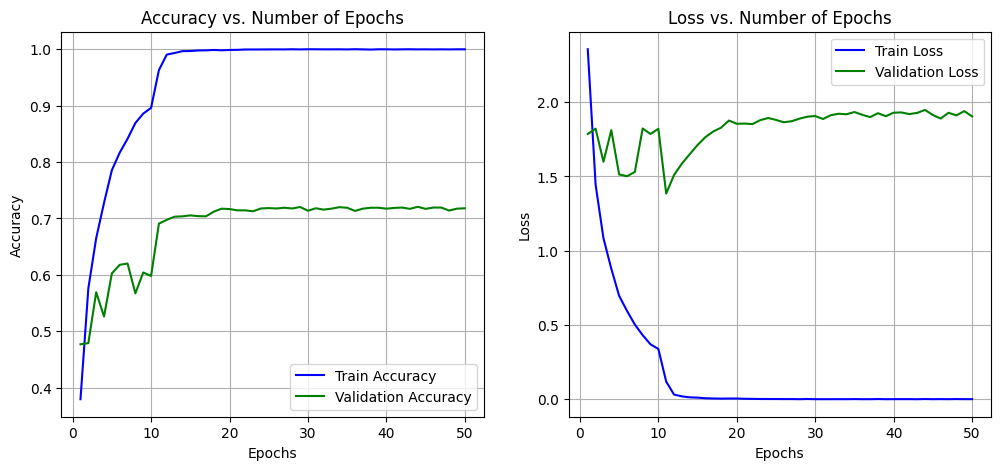

Highest Validation Accuracy: 72.07%


In [23]:
# Define the loss function (Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam, learning rate 0.0005)
optimizer = optim.Adam(vgg16_bn_model.parameters(), lr=0.0005)

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce LR by factor of 0.1 every 10 epochs

# Define the number of epochs
num_epochs = 50

# Initialize lists to store the accuracies and losses at each epoch
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []
# Initialize the best accuracy
best_accuracy = 0.0

# Initialize the progress bar for better visualization of the training progress
progress_bar = tqdm(range(num_epochs), desc="Training Progress", dynamic_ncols=True)

# Training loop with progress bar
for epoch in progress_bar:
    ## Training ##
    train_loss, train_accuracy = indv_epoch_train(vgg16_bn_model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    ## Evaluation ##
    val_loss, val_accuracy = evaluate_model(vgg16_bn_model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Step the scheduler
    scheduler.step()

    # Save the best model as a checkpoint 
    best_accuracy = save_model(vgg16_bn_model, vgg16_bn_model_path, val_accuracy, best_accuracy, epoch, optimizer)

    # Update the progress bar with metrics
    progress_bar.set_postfix_str(
        f"Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}"
    )

# Plot the accuracy against the number of epochs
metric_plot(train_accuracies, val_accuracies, train_losses, val_losses, num_epochs)

best_acc_percent = 100 * best_accuracy
# Print the highest accuracy achieved
print(f"Highest Validation Accuracy: {best_acc_percent:.2f}%")

In [24]:
# Get a random image path
img_path = random.choice(test_set)[0]

# Print the image path
print(f"Image Path: {img_path}")

# Predict the breed
breed, confidence = predict(vgg16_bn_model, vgg16_bn_model_path, img_path, label_dict)

print(f"Predicted Breed: {breed}")
print(f"Confidence: {confidence:.2f}%")

Image Path: /opt/nfs/shared/images/ImageNetDogs/Images/n02111500-Great_Pyrenees/n02111500_124.jpg
Predicted Breed: n02111500-Great_Pyrenees
Confidence: 99.98%


Try to improve the performance, by varying characteristics such as the model hyperparameters, and train *at least* 2 additional models.

For each model, explain the reasoning behind (1) the *characteristics* chosen for modification, and (2) the *values* that are set (e.g. if you reduce the learning rate, explain why you have done this).

*ℹ️ NOTE: As before, the models should take less than 2.5 hours each to train.*

In [25]:
# Model imporvement 1: Global Average Pooling to mitigate overfitting

# Clone the VGG16_bn model for the GAP model
gap_vgg16_bn_model = vgg16_bn_model.clone()

# Replace the last fully connected layer (index 6 of the original classifier)
gap_vgg16_bn_model.classifier[6] = nn.Identity()  # Placeholder to remove the original FC layer

# Add Global Average Pooling (GAP) after the convolutional feature extractor
gap_vgg16_bn_model.add_module('gap', nn.AdaptiveAvgPool2d((1, 1)))

# Add a fully connected (FC) layer to map GAP output to the desired number of classes
gap_vgg16_bn_model.add_module('fc', nn.Sequential(
    nn.Flatten(),                 # Flatten the (512, 1, 1) into (512)
    nn.Linear(512, num_classes)   # Map to the number of classes
    # Note the gap reduces the spatial dimensions to 1x1 and the flatten layer reduces the dimensions to 512 from the 4096
))

# Move the model to the correct device
gap_vgg16_bn_model = gap_vgg16_bn_model.to(device)

# Set the model path
gap_vgg16_bn_model_path = './Model/VGG16/gap_vgg16_bn_model.pth'


AttributeError: 'VGG' object has no attribute 'clone'

In [26]:
 # Define the loss function (Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam, learning rate 0.0005)
optimizer = optim.Adam(gap_vgg16_bn_model.parameters(), lr=0.0005)

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce LR by factor of 0.1 every 10 epochs

# Define the number of epochs
num_epochs = 50

# Initialize lists to store the accuracies and losses at each epoch
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []
# Initialize the best accuracy
best_accuracy = 0.0

# Initialize the progress bar for better visualization of the training progress
progress_bar = tqdm(range(num_epochs), desc="Training Progress", dynamic_ncols=True)

# Training loop with progress bar
for epoch in progress_bar:
    ## Training ##
    train_loss, train_accuracy = indv_epoch_train(gap_vgg16_bn_model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    ## Evaluation ##
    val_loss, val_accuracy = evaluate_model(gap_vgg16_bn_model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Step the scheduler
    scheduler.step()

    # Save the best model as a checkpoint 
    best_accuracy = save_model(gap_vgg16_bn_model, gap_vgg16_bn_model_path, val_accuracy, best_accuracy, epoch, optimizer)

    # Update the progress bar with metrics
    progress_bar.set_postfix_str(
        f"Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}"
    )

# Plot the accuracy against the number of epochs
metric_plot(train_accuracies, val_accuracies, train_losses, val_losses, num_epochs)

best_acc_percent = 100 * best_accuracy
# Print the highest accuracy achieved
print(f"Highest Validation Accuracy: {best_acc_percent:.2f}%")

NameError: name 'gap_vgg16_bn_model' is not defined

In [27]:
# Get a random image path
img_path = random.choice(test_set)[0]

# Print the image path
print(f"Image Path: {img_path}")

# Predict the breed
breed, confidence = predict(gap_vgg16_bn_model, gap_vgg16_bn_model_path, img_path, label_dict)

print(f"Predicted Breed: {breed}")
print(f"Confidence: {confidence:.2f}%")

Image Path: /opt/nfs/shared/images/ImageNetDogs/Images/n02085782-Japanese_spaniel/n02085782_626.jpg


NameError: name 'gap_vgg16_bn_model' is not defined

## Conclusions & Future Work

### **Q11: Model Deployment** ###

Let's say that you are asked to deploy one of your models in practice. Which of the models that you have trained would you select, and why?

ℹ️ *NOTE: Compare your models, and discuss any advantages, limitations, and any future work that could be performed to make the chosen model more suitable for real-world deployment.*

**(10 marks)**

**A11**: Write your answer here.




**END OF ASSIGNMENT**

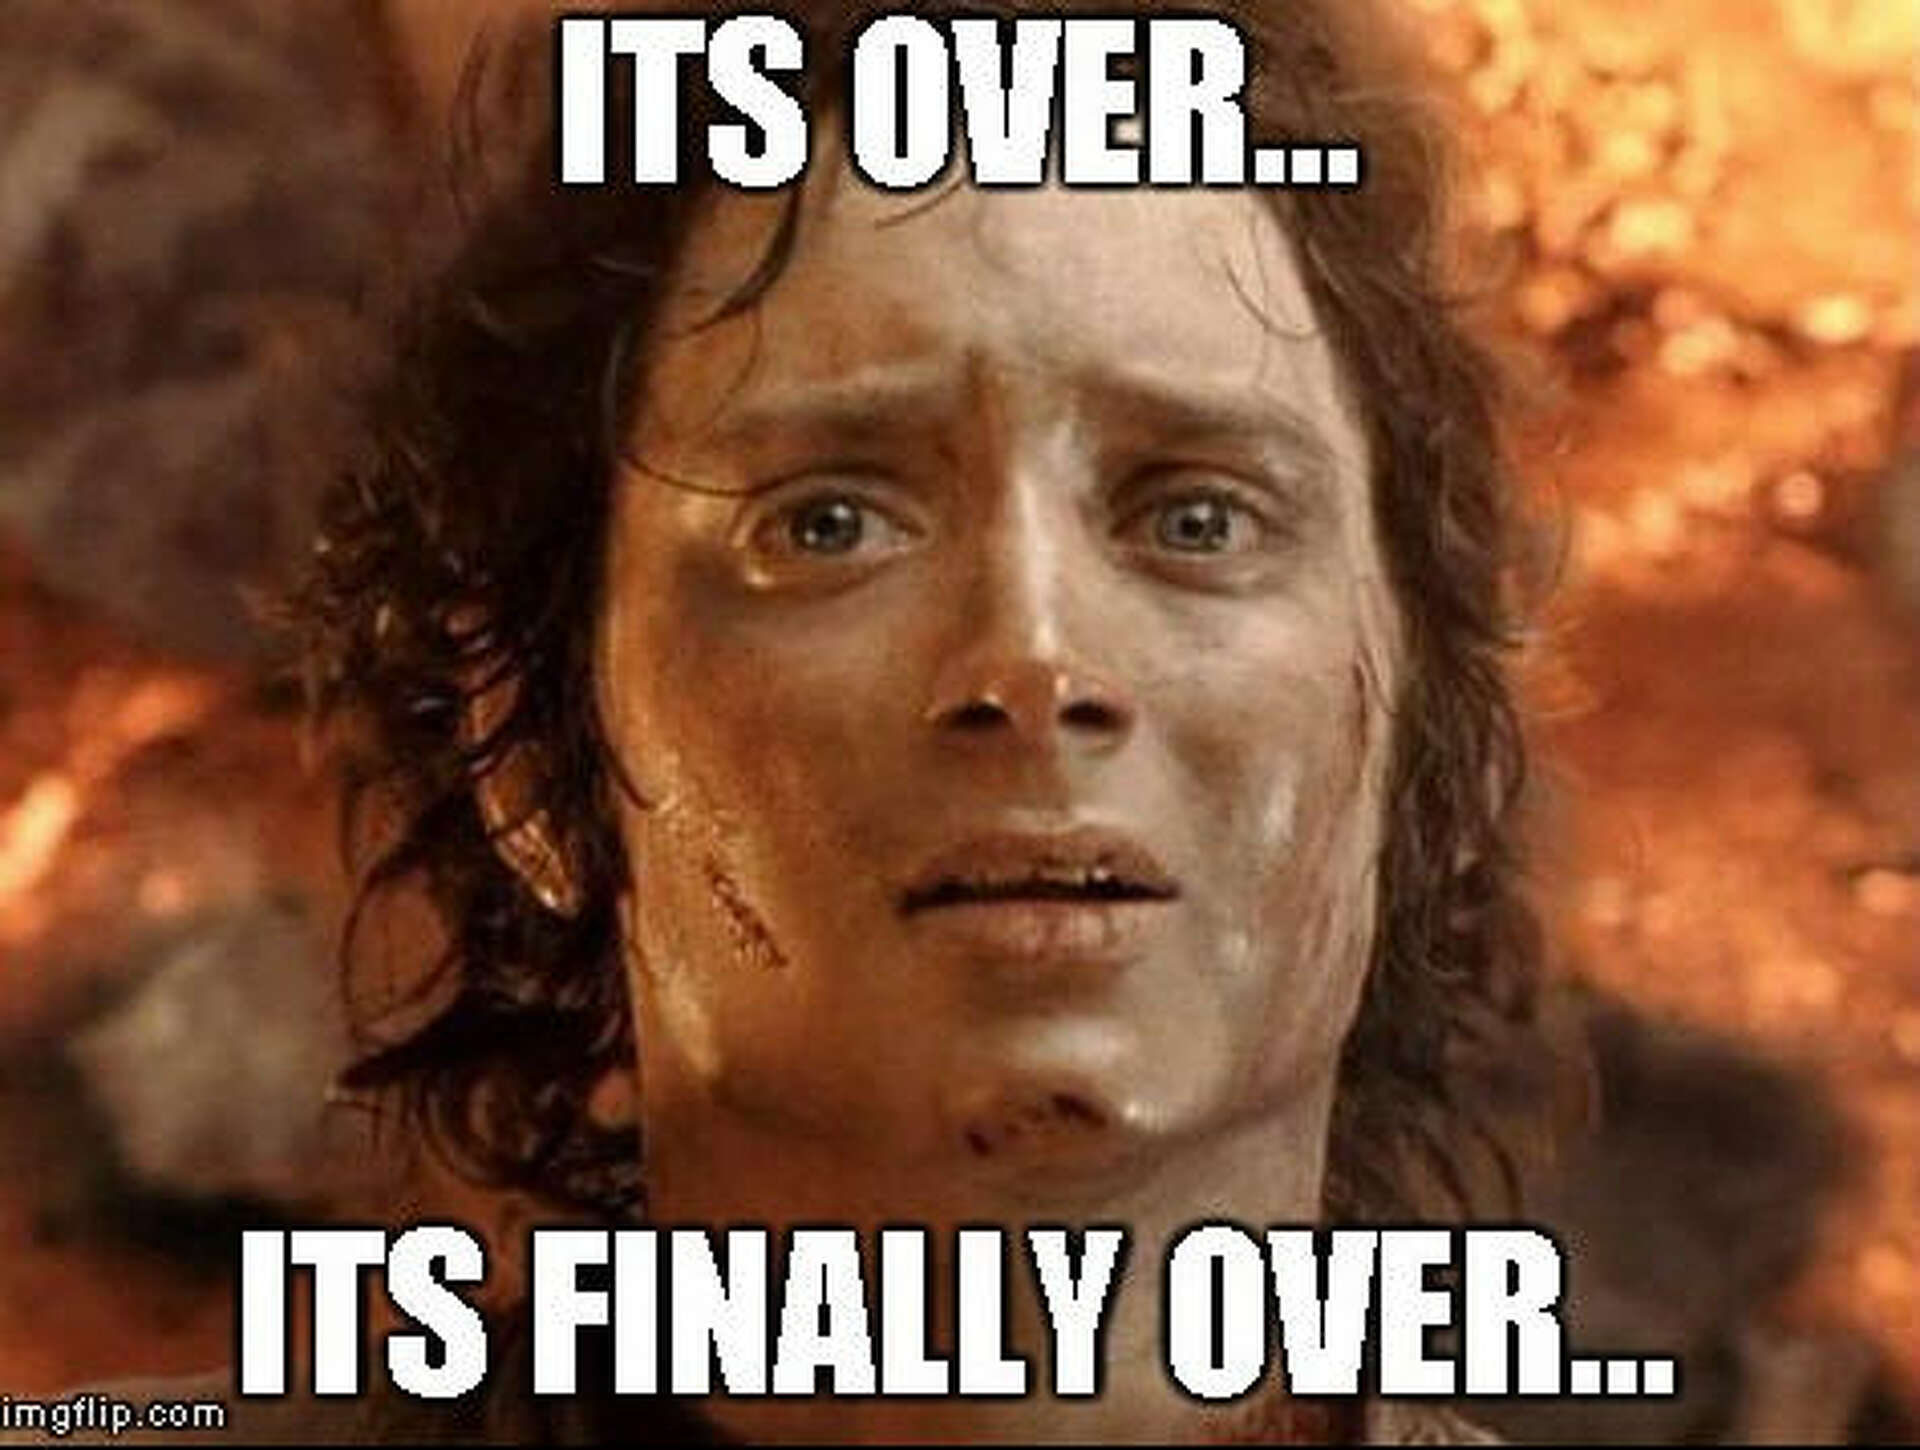